# Временные ряды

In [1]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [56]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### Белый шум

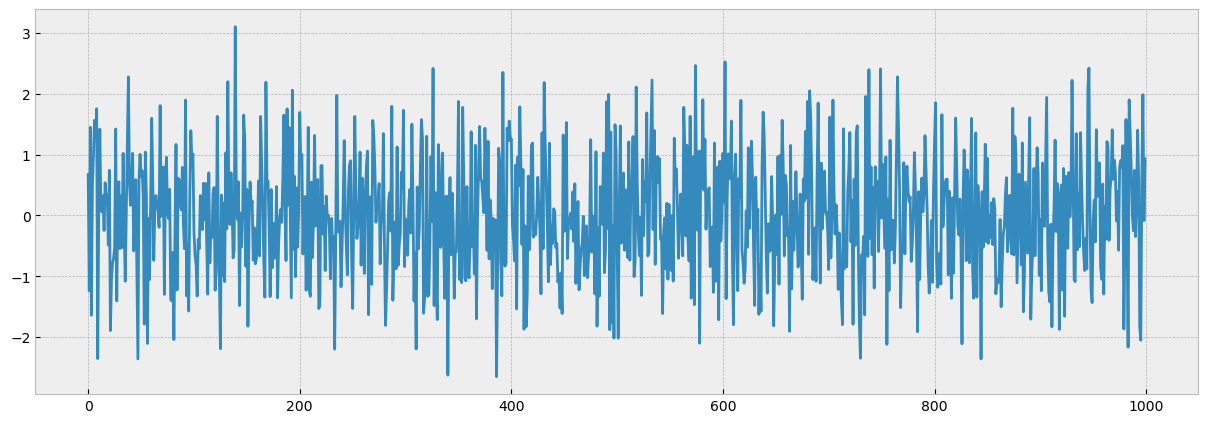

In [2]:
white_noise = np.random.normal(size=1000)
with plt.style.context('bmh'):  
    plt.figure(figsize=(15, 5))
    plt.plot(white_noise)

## Пример 1: Встречи с НЛО

In [3]:
data = pd.read_csv('ufo.csv')
data.head()

,City,Colors Reported,Shape Reported,State,Time
0,Ithaca,NaN,TRIANGLE,NY,6/1/1930 22:00
1,Willingboro,NaN,OTHER,NJ,6/30/1930 20:00
2,Holyoke,NaN,OVAL,CO,2/15/1931 14:00
3,Abilene,NaN,DISK,KS,6/1/1931 13:00
4,New York Worlds Fair,NaN,LIGHT,NY,4/18/1933 19:00


In [4]:
data.info() #в колонке Time строки

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18241 entries, 0 to 18240
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   City             18215 non-null  object
 1   Colors Reported  2882 non-null   object
 2   Shape Reported   15597 non-null  object
 3   State            18241 non-null  object
 4   Time             18241 non-null  object
dtypes: object(5)
memory usage: 712.7+ KB


In [5]:
data['Time'][0]

'6/1/1930 22:00'

In [6]:
type(data['Time'][0])

str

In [7]:
data['Time'] = pd.to_datetime(data['Time']) #преобразуем в формат, позволяющий работать с датами
data['Time'][0]

Timestamp('1930-06-01 22:00:00')

In [8]:
type(data['Time'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [9]:
data.head() # видим, что и вид данных в столбце Time поменялся

,City,Colors Reported,Shape Reported,State,Time
0,Ithaca,NaN,TRIANGLE,NY,1930-06-01 22:00:00
1,Willingboro,NaN,OTHER,NJ,1930-06-30 20:00:00
2,Holyoke,NaN,OVAL,CO,1931-02-15 14:00:00
3,Abilene,NaN,DISK,KS,1931-06-01 13:00:00
4,New York Worlds Fair,NaN,LIGHT,NY,1933-04-18 19:00:00


Так как это теперь объект timestamp, в его атрибутах находятся элементы даты, и мы можем к ним обращаться через ключевые слова.

In [10]:
data['Time'][0].year #год

1930

In [11]:
data['Time'][0].month #месяц

6

In [12]:
data['Time'][0].day #день

1

In [13]:
data['Time'][0].hour #час

22

In [14]:
data['Time'][0].minute #минута

0

In [15]:
data['Time'][0].second #секунда

0

In [16]:
data['Time'][0].week #номер недели

22

In [17]:
data['Time'][0].day_name() #день недели

'Sunday'

In [18]:
data['Time'].dt.year.head() # вызвали колонку, обратились к атбриту .dt, выбрали в нем year, получили колонку заполненную годами.

0    1930
1    1930
2    1931
3    1931
4    1933
Name: Time, dtype: int32

In [19]:
data['Time'].dt.day_name().head() 

0     Sunday
1     Monday
2     Sunday
3     Monday
4    Tuesday
Name: Time, dtype: object

Посмотрим сколько НЛО видели в разные годы.

<Axes: xlabel='Time'>

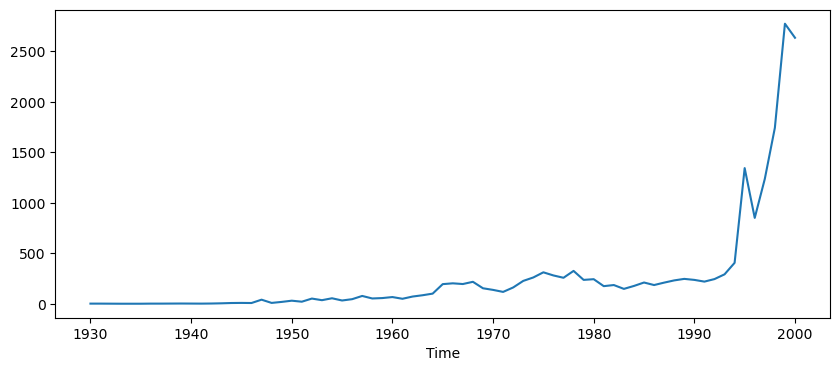

In [20]:
plt.figure(figsize=(10, 4))
data.groupby(data['Time'].dt.year).size().plot()

Число НЛО по дням недели.

<Axes: xlabel='Time'>

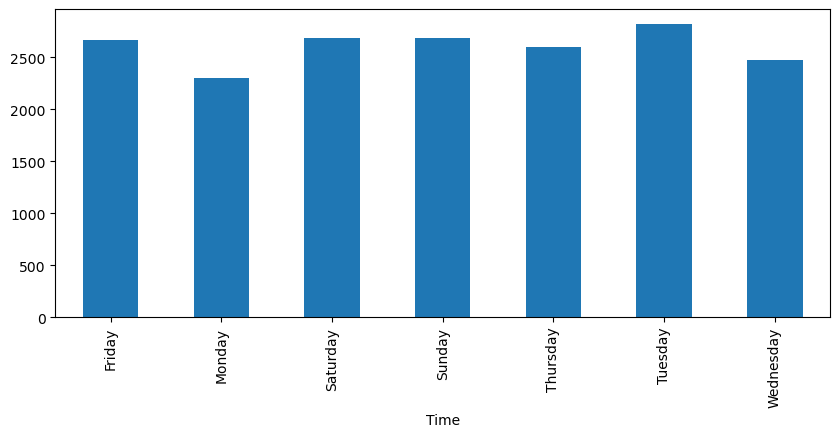

In [21]:
plt.figure(figsize=(10, 4))
data.groupby(data['Time'].dt.day_name()).size().plot(kind = 'bar') #

Число НЛО по часам.

<Axes: xlabel='Time'>

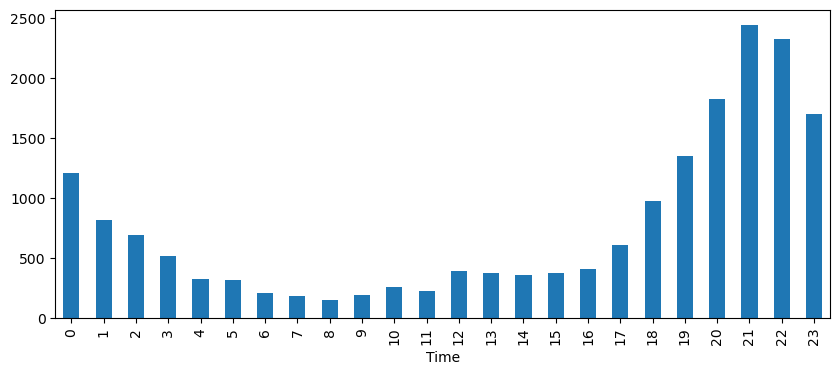

In [22]:
plt.figure(figsize=(10, 4))
data.groupby(data['Time'].dt.hour).size().plot(kind = 'bar') #

Колонку timestamp можно сделать индексом.

In [23]:
data.index = data['Time']
data.head()

,City,Colors Reported,Shape Reported,State,Time
Time,,,,,
1930-06-01 22:00:00,Ithaca,NaN,TRIANGLE,NY,1930-06-01 22:00:00
1930-06-30 20:00:00,Willingboro,NaN,OTHER,NJ,1930-06-30 20:00:00
1931-02-15 14:00:00,Holyoke,NaN,OVAL,CO,1931-02-15 14:00:00
1931-06-01 13:00:00,Abilene,NaN,DISK,KS,1931-06-01 13:00:00
1933-04-18 19:00:00,New York Worlds Fair,NaN,LIGHT,NY,1933-04-18 19:00:00


In [24]:
data.loc["2000-06-01"].head(5) #значения на определённую дату

,City,Colors Reported,Shape Reported,State,Time
Time,,,,,
2000-06-01 00:00:00,Joshua Tree National Park,NaN,OVAL,CA,2000-06-01 00:00:00
2000-06-01 01:00:00,Auburn,NaN,OVAL,WA,2000-06-01 01:00:00
2000-06-01 02:00:00,San Francisco,NaN,FORMATION,CA,2000-06-01 02:00:00
2000-06-01 12:00:00,Powhatan,NaN,LIGHT,VA,2000-06-01 12:00:00
2000-06-01 13:00:00,Livonia,NaN,DISK,MI,2000-06-01 13:00:00


In [25]:
data.loc["June 1 2000"].head(5) # то же самое

,City,Colors Reported,Shape Reported,State,Time
Time,,,,,
2000-06-01 00:00:00,Joshua Tree National Park,NaN,OVAL,CA,2000-06-01 00:00:00
2000-06-01 01:00:00,Auburn,NaN,OVAL,WA,2000-06-01 01:00:00
2000-06-01 02:00:00,San Francisco,NaN,FORMATION,CA,2000-06-01 02:00:00
2000-06-01 12:00:00,Powhatan,NaN,LIGHT,VA,2000-06-01 12:00:00
2000-06-01 13:00:00,Livonia,NaN,DISK,MI,2000-06-01 13:00:00


In [26]:
data.loc["June 2000"].head() #за целый месяц

,City,Colors Reported,Shape Reported,State,Time
Time,,,,,
2000-06-01 00:00:00,Joshua Tree National Park,NaN,OVAL,CA,2000-06-01 00:00:00
2000-06-01 01:00:00,Auburn,NaN,OVAL,WA,2000-06-01 01:00:00
2000-06-01 02:00:00,San Francisco,NaN,FORMATION,CA,2000-06-01 02:00:00
2000-06-01 12:00:00,Powhatan,NaN,LIGHT,VA,2000-06-01 12:00:00
2000-06-01 13:00:00,Livonia,NaN,DISK,MI,2000-06-01 13:00:00


## Пример 2: Пассажиры авиакомпаний (моделирование)

In [27]:
df = pd.read_csv("AirPassengers.csv")
df

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [29]:
df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m') #изменим тип данных в столбце Month
df #поскольку число месяца не указано, везде установлено 1-ое число

,Month,#Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121
...,...,...
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461
142,1960-11-01,390


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Month        144 non-null    datetime64[ns]
 1   #Passengers  144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB


In [31]:
df.index = df['Month']
del df['Month']
df

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


Text(0, 0.5, 'Number of Passengers')

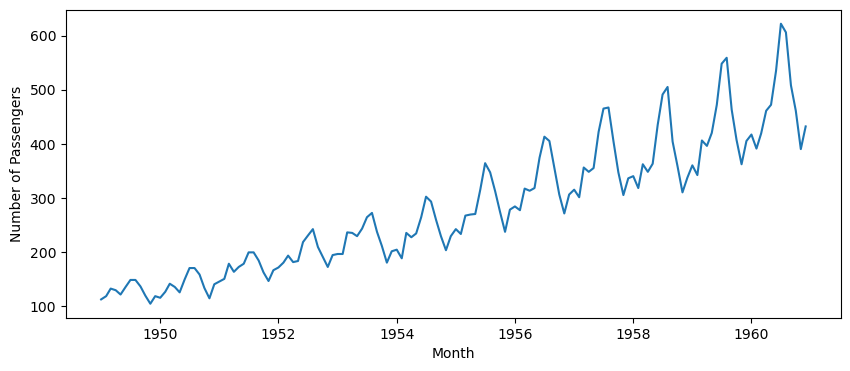

In [32]:
plt.figure(figsize=(10, 4))
sns.lineplot(data=df, x=df.index, y=df['#Passengers']) # визуализируем временной ряд
plt.ylabel('Number of Passengers')

В данных наблюдается тренд и сезонность.

### Декомпозиция ряда

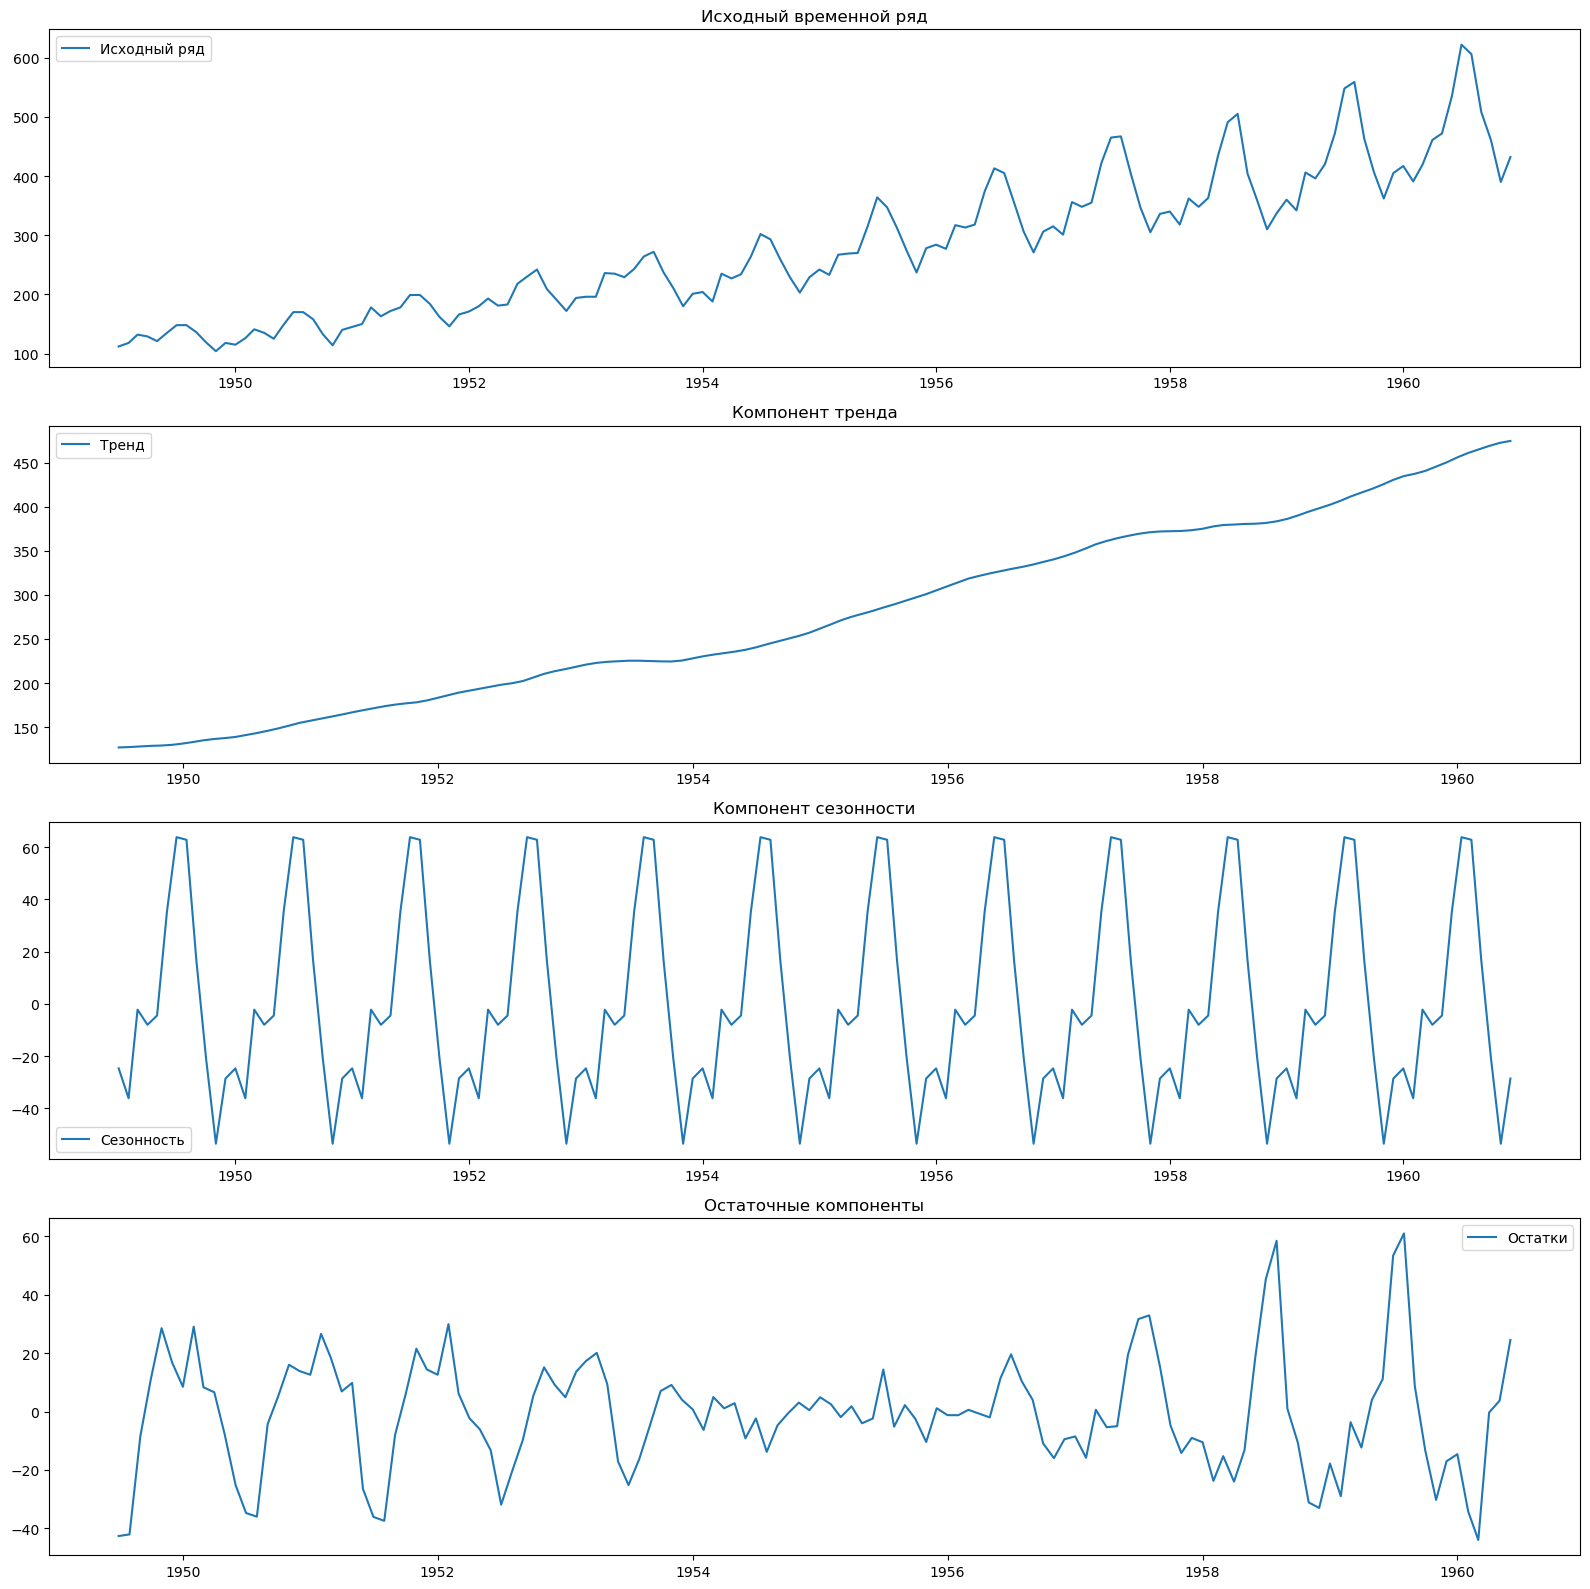

In [33]:
decomposition = seasonal_decompose(df, model='additive')

# Извлечение компонентов тренда, сезонности и остатков
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(16, 16))

# График исходного временного ряда
plt.subplot(411)
plt.plot(df.index, df['#Passengers'], label='Исходный ряд')
plt.legend(loc='best')
plt.title('Исходный временной ряд')


# График компонента тренда
plt.subplot(412)
plt.plot(trend, label='Тренд')
plt.legend(loc='best')
plt.title('Компонент тренда')

# График компонента сезонности
plt.subplot(413)
plt.plot(seasonal, label='Сезонность')
plt.legend(loc='best')
plt.title('Компонент сезонности')

# График остаточных компонентов
plt.subplot(414)
plt.plot(residual, label='Остатки')
plt.legend(loc='best')
plt.title('Остаточные компоненты')

plt.tight_layout()
plt.show()

### Скользящее среднее

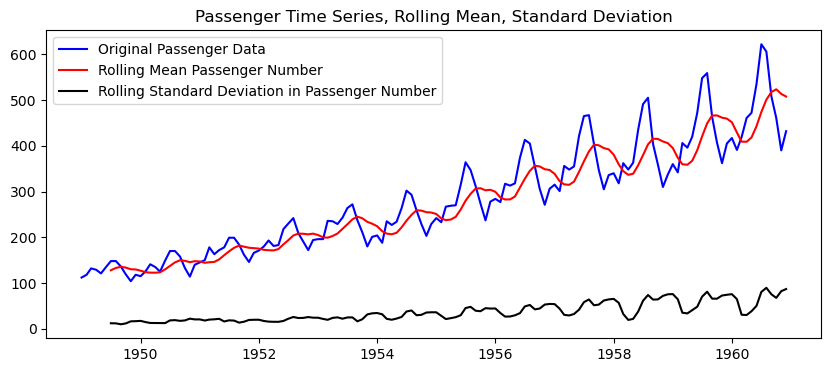

In [34]:
plt.figure(figsize=(10, 4))
plt.plot(df, color="blue",label="Original Passenger Data") #исходные данные
rolling_mean = df.rolling(7).mean() #скользящее среднее за 7 месяцев
plt.plot(rolling_mean, color="red", label="Rolling Mean Passenger Number") 
rolling_std = df.rolling(7).std() #скользящее стандартное отклонение за 7 месяцев
plt.plot(rolling_std, color="black", label = "Rolling Standard Deviation in Passenger Number")
plt.title("Passenger Time Series, Rolling Mean, Standard Deviation")
plt.legend(loc="best")

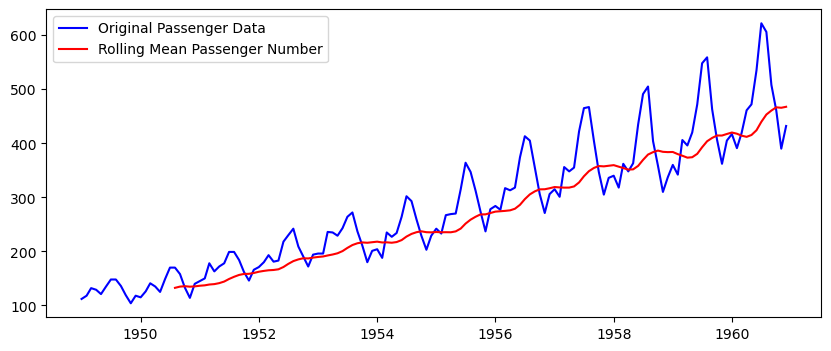

In [35]:
plt.figure(figsize=(10, 4))
plt.plot(df, color="blue",label="Original Passenger Data") #исходные данные
rolling_mean = df.rolling(20).mean() #скользящее среднее за 20 месяцев
plt.plot(rolling_mean, color="red", label="Rolling Mean Passenger Number") 
plt.legend(loc="best")

### Тест Дики — Фуллера на стационарность

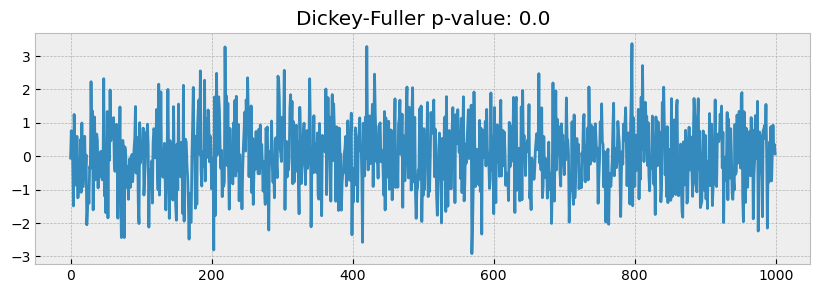

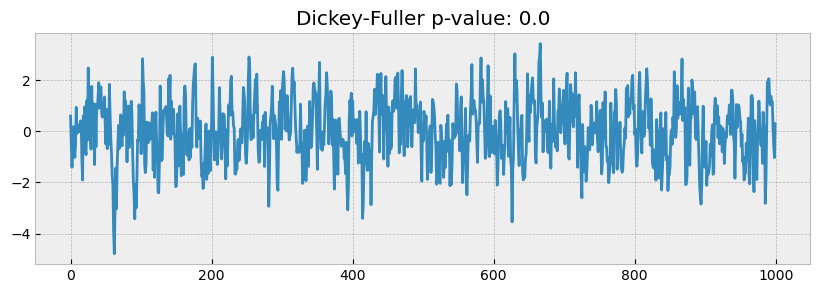

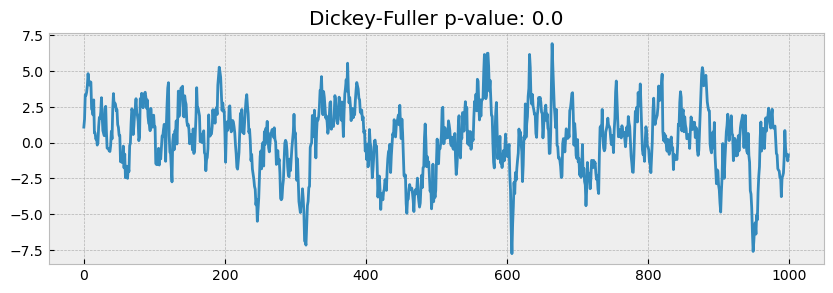

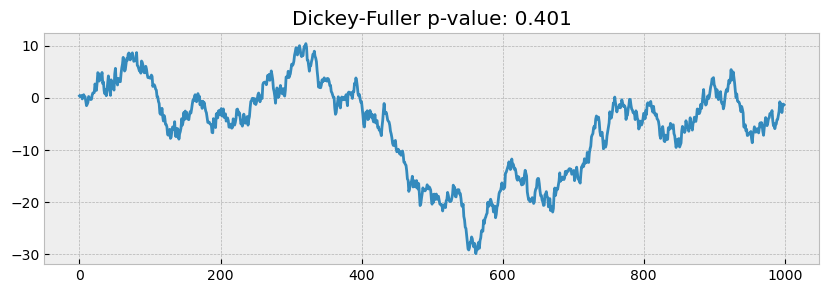

In [36]:
def plotProcess(n_samples=1000, rho=0):
    x = w = np.random.normal(size=n_samples)
    for t in range(n_samples):
        x[t] = rho * x[t-1] + w[t]

    with plt.style.context('bmh'):  
        plt.figure(figsize=(10, 3))
        plt.plot(x)
        plt.title("Dickey-Fuller p-value: {}".format(round(sm.tsa.stattools.adfuller(x)[1], 3)))
        
for rho in [0, 0.6, 0.9, 1]:
    plotProcess(rho=rho)

In [37]:
from statsmodels.tsa.stattools import adfuller #Тест Дики — Фуллера на стационарность 
adft = adfuller(df)
#Если p-value<0.05, то ряд стационарный

In [38]:
print('p-value: ', adft[1])

p-value:  0.9918802434376409


Вывод: ряд не является стационарным. Это закономерно, поскольку в нём присутствуют явный тренд и сезонность.

In [39]:
df['#Passengers_dif1'] = df['#Passengers'] - df['#Passengers'].shift(1) #один раз дифференцируем ряд
adft = adfuller(df['#Passengers_dif1'].dropna(),autolag="AIC")
print('p-value: ', adft[1])

p-value:  0.05421329028382552


Однократно дифференцированный ряд ближе к стационарному.

In [40]:
df['#Passengers_dif2'] = df['#Passengers'] - df['#Passengers'].shift(2) #два раза дифференцируем ряд
adft = adfuller(df['#Passengers_dif2'].dropna(),autolag="AIC")
print('p-value: ', adft[1])

p-value:  0.03862975767698839


Двукратно дифференцированный ряд стал стационарным на 5% уровне значимости.

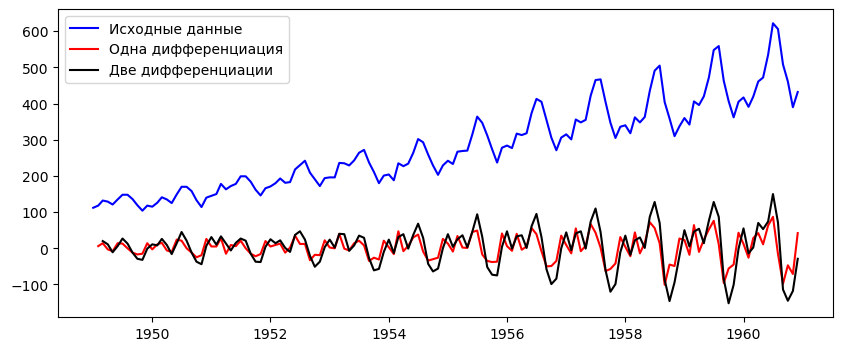

In [41]:
plt.figure(figsize=(10, 4))
plt.plot(df['#Passengers'], color="blue",label="Исходные данные")
plt.plot(df['#Passengers_dif1'], color="red", label="Одна дифференциация")
plt.plot(df['#Passengers_dif2'], color="black", label = "Две дифференциации") 
plt.legend(loc="best")

### Автокорреляция

In [42]:
autocorrelation_lag1 = df['#Passengers'].autocorr(lag=1)
print("One Month Lag: ", autocorrelation_lag1)
#коэффициент автокорреляции с лагом 1

One Month Lag:  0.9601946480498524


In [43]:
autocorrelation_lag3 = df['#Passengers'].autocorr(lag=3)#коэффициент автокорреляции с лагом 3
print("Three Month Lag: ", autocorrelation_lag3)

autocorrelation_lag6 = df['#Passengers'].autocorr(lag=6) #коэффициент автокорреляции с лагом 6
print("Six Month Lag: ", autocorrelation_lag6)

autocorrelation_lag9 = df['#Passengers'].autocorr(lag=9) #коэффициент автокорреляции с лагом 9
print("Nine Month Lag: ", autocorrelation_lag9)

Three Month Lag:  0.8373947650817946
Six Month Lag:  0.7839187959206181
Nine Month Lag:  0.8278519011167608


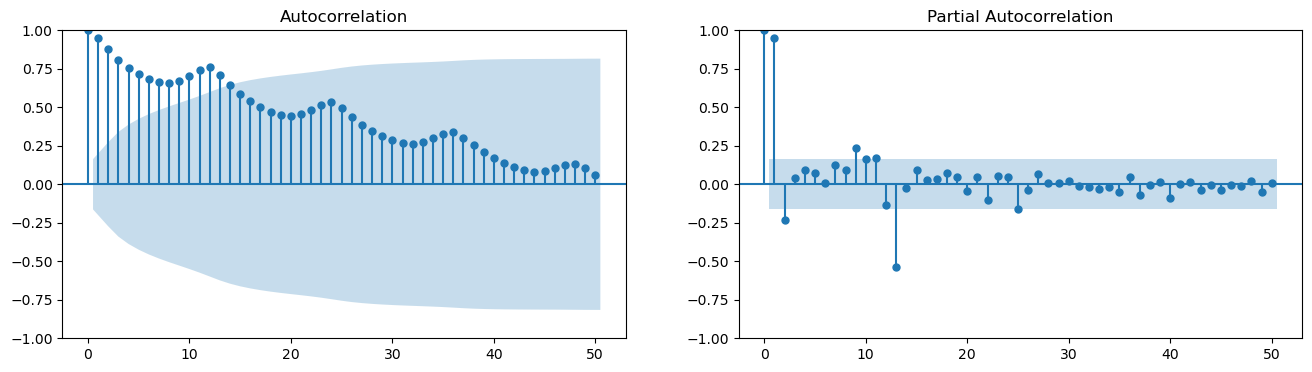

In [44]:
fig, axes = plt.subplots(1,2,figsize=(16,4), dpi= 100)
plot_acf(df['#Passengers'], lags=50, ax=axes[0])
plot_pacf(df['#Passengers'], lags=50, ax=axes[1])
plt.show()

### Разделение ряда на обучающую и тестовую выборки

Обучающая выборка: данные до августа 1960.

In [45]:
df = pd.read_csv("AirPassengers.csv")
df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m')
df.index = df['Month']
del df['Month']

In [46]:
df['Date'] = df.index
train = df[df['Date'] < "1960-08"]
del train['Date']
train = train.rename(columns={'#Passengers': 'train'}) 
train

,train
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-03-01,419
1960-04-01,461
1960-05-01,472


Тестовая выборка: данные после августа 1960 включительно.

In [47]:
test = df[df['Date'] >= "1960-08"]
del test['Date']
test = test.rename(columns={'#Passengers': 'test'}) 
test

,test
Month,
1960-08-01,606
1960-09-01,508
1960-10-01,461
1960-11-01,390
1960-12-01,432


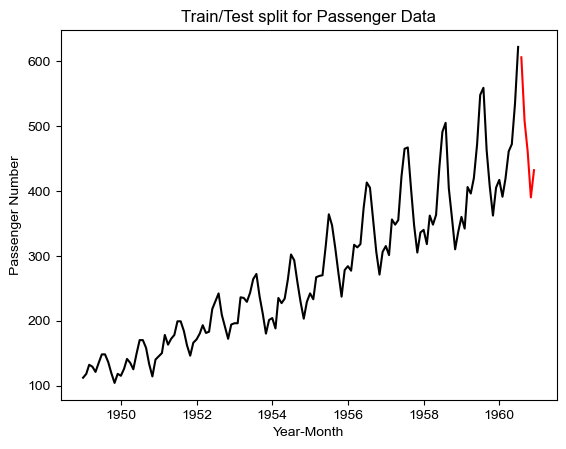

In [48]:
plt.plot(train, color = "black") #обучающая выборка
plt.plot(test, color = "red") #тестовая выборка
plt.title("Train/Test split for Passenger Data")
plt.ylabel("Passenger Number")
plt.xlabel('Year-Month')
sns.set()
plt.show()

### ARIMA

In [49]:
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train)
forecast = model.predict(n_periods=len(test))
forecast = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1352.593, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1340.702, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1336.259, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1352.415, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1329.986, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1335.098, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1336.923, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1329.407, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1335.407, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1339.796, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1325.560, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1336.3

Информационный критерий — применяемая в эконометрике (статистике) мера относительного качества эконометрических (статистических) моделей, учитывающая степень «подгонки» модели под данные с корректировкой (штрафом) на используемое количество оцениваемых параметров. То есть критерии основаны на компромиссе между точностью и сложностью модели. 

Информационный критерий Акаике (Akaike Information Critera) позволяет сравнивать модели. Чем меньше значение критерия, тем лучше модель. 

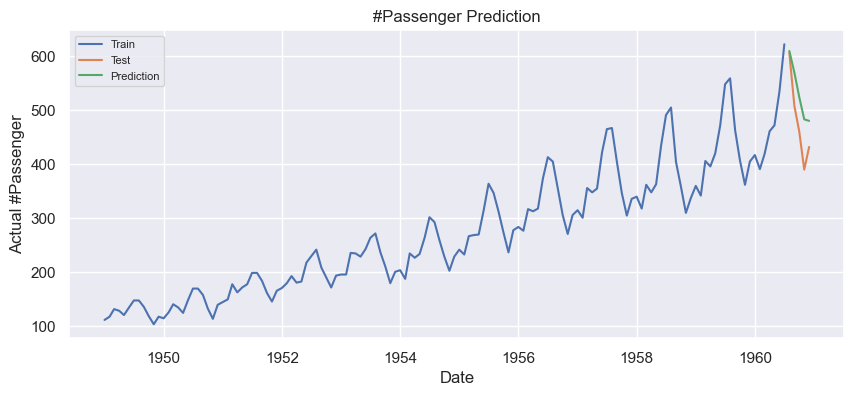

In [50]:
plt.figure(figsize=(10, 4))
plt.plot(train, label='Train') #обучающая выборка
plt.plot(test, label='Test') #тестовая выборка
plt.plot(forecast, label='Prediction') #предсказанные значения

plt.title('#Passenger Prediction')
plt.xlabel('Date')
plt.ylabel('Actual #Passenger')
plt.legend(loc='upper left', fontsize=8)


In [51]:
df.index = pd.DatetimeIndex(df.index.values, freq=df.index.inferred_freq)

In [52]:
model  =  ARIMA(df['#Passengers'], order=(1, 1, 1))
res = model.fit()
print(res.summary())
#это пример плохой модели

                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -694.341
Date:                Mon, 27 Jan 2025   AIC                           1394.683
Time:                        14:30:53   BIC                           1403.571
Sample:                    01-01-1949   HQIC                          1398.294
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4742      0.123     -3.847      0.000      -0.716      -0.233
ma.L1          0.8635      0.078     11.051      0.000       0.710       1.017
sigma2       961.9270    107.433      8.954      0.0

In [57]:
predictions = res.predict(start=test.index[0], end=test.index[-1])
mse = mean_squared_error(test, predictions)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 942.8010478107866


In [58]:
model  =  ARIMA(df['#Passengers'], order=(4, 1, 3))
res = model.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(4, 1, 3)   Log Likelihood                -674.913
Date:                Mon, 27 Jan 2025   AIC                           1365.825
Time:                        14:34:21   BIC                           1389.528
Sample:                    01-01-1949   HQIC                          1375.457
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5582      0.117     -4.782      0.000      -0.787      -0.329
ar.L2          0.4935      0.113      4.375      0.000       0.272       0.715
ar.L3          0.1238      0.128      0.970      0.3

In [59]:
predictions = res.predict(start=test.index[0], end=test.index[-1])
mse = mean_squared_error(test, predictions)
print(f"Mean Squared Error: {mse}")
#MSE значительно снизился

Mean Squared Error: 942.8010478107866


<Axes: >

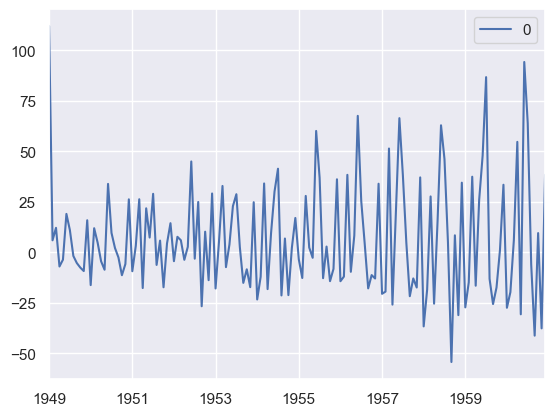

In [60]:
# визуализация остатков
residuals = pd.DataFrame(res.resid)
residuals.plot()

## Пример 3. Восстановление пропусков

In [61]:
time_index = pd.date_range("1/01/2021", periods=6, freq="W")
df = pd.DataFrame(index=time_index);
print(df)
df["Sales"] = [5.0,4.0,np.nan,np.nan,1.0,np.nan];
print(df)

Empty DataFrame
Columns: []
Index: [2021-01-03 00:00:00, 2021-01-10 00:00:00, 2021-01-17 00:00:00, 2021-01-24 00:00:00, 2021-01-31 00:00:00, 2021-02-07 00:00:00]
            Sales
2021-01-03    5.0
2021-01-10    4.0
2021-01-17    NaN
2021-01-24    NaN
2021-01-31    1.0
2021-02-07    NaN


In [62]:
#Interpolating missing values
df1= df.interpolate();
print(df1)

            Sales
2021-01-03    5.0
2021-01-10    4.0
2021-01-17    3.0
2021-01-24    2.0
2021-01-31    1.0
2021-02-07    1.0


In [63]:
#Forward-fill Missing Values - Using value of next row to fill the missing value
df2 = df.ffill()
print(df2)

            Sales
2021-01-03    5.0
2021-01-10    4.0
2021-01-17    4.0
2021-01-24    4.0
2021-01-31    1.0
2021-02-07    1.0


In [64]:
#Backfill Missing Values - Using value of previous row to fill the missing value
df3 = df.bfill();
print(df3)

            Sales
2021-01-03    5.0
2021-01-10    4.0
2021-01-17    1.0
2021-01-24    1.0
2021-01-31    1.0
2021-02-07    NaN


In [65]:
#Interpolating Missing Values But Only Up One Value
df4 = df.interpolate(limit=1, limit_direction="forward");
print(df4)

            Sales
2021-01-03    5.0
2021-01-10    4.0
2021-01-17    3.0
2021-01-24    NaN
2021-01-31    1.0
2021-02-07    1.0


In [66]:
#Interpolating Missing Values But Only Up Two Values
df5 = df.interpolate(limit=2, limit_direction="forward");
print(df5)

            Sales
2021-01-03    5.0
2021-01-10    4.0
2021-01-17    3.0
2021-01-24    2.0
2021-01-31    1.0
2021-02-07    1.0


<Axes: title={'center': 'Cubic Fill (MSE: 4.11)'}, xlabel='date'>

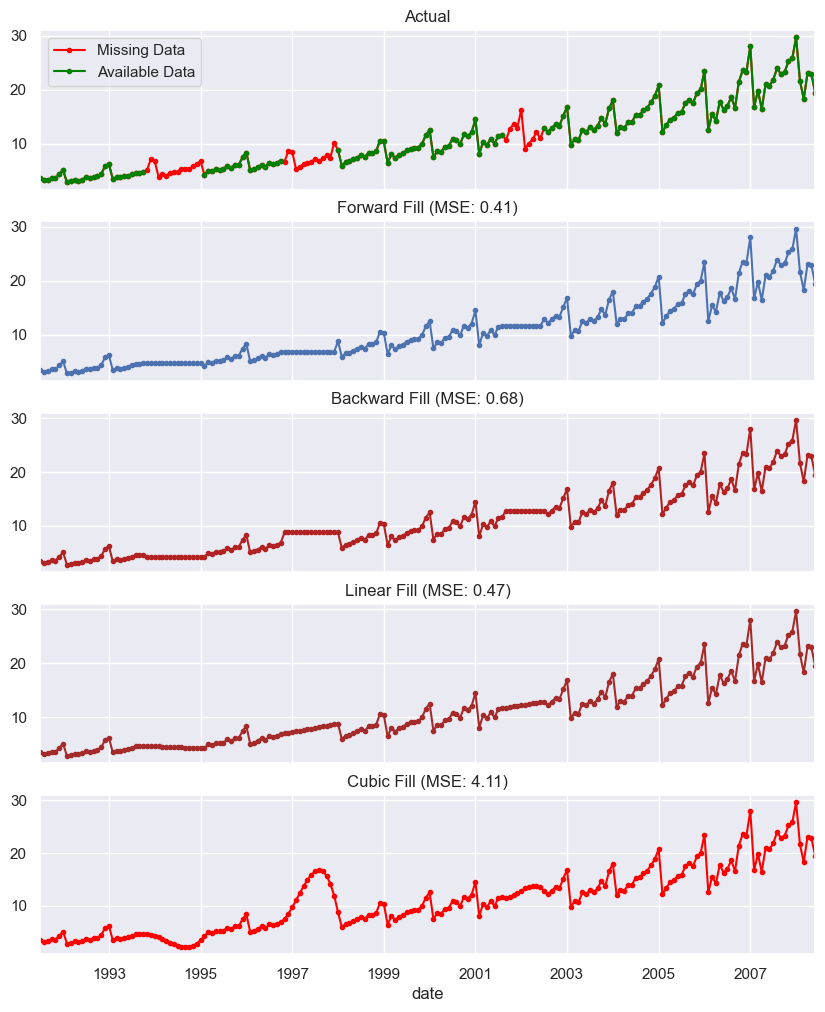

In [67]:
# # Generate dataset
from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error
df_orig = pd.read_csv('a10.csv', parse_dates=['date'], index_col='date')
df = pd.read_csv('a10_missings.csv', parse_dates=['date'], index_col='date', sep=';')

fig, axes = plt.subplots(5, 1, sharex=True, figsize=(10, 12))
plt.rcParams.update({'xtick.bottom' : False})

## 1. Actual -------------------------------
df_orig.plot(title='Actual', ax=axes[0], label='Actual', color='red', style=".-")
df.plot(title='Actual', ax=axes[0], label='Actual', color='green', style=".-")
axes[0].legend(["Missing Data", "Available Data"])

## 2. Forward Fill --------------------------
df_ffill = df.ffill()
error = np.round(mean_squared_error(df_orig['value'], df_ffill['value']), 2)
df_ffill['value'].plot(title='Forward Fill (MSE: ' + str(error) +")", ax=axes[1], label='Forward Fill', style=".-")

## 3. Backward Fill -------------------------
df_bfill = df.bfill()
error = np.round(mean_squared_error(df_orig['value'], df_bfill['value']), 2)
df_bfill['value'].plot(title="Backward Fill (MSE: " + str(error) +")", ax=axes[2], label='Back Fill', color='firebrick', style=".-")

## 4. Linear Interpolation ------------------
df['rownum'] = np.arange(df.shape[0])
df_nona = df.dropna(subset = ['value'])
f = interp1d(df_nona['rownum'], df_nona['value'])
df['linear_fill'] = f(df['rownum'])
error = np.round(mean_squared_error(df_orig['value'], df['linear_fill']), 2)
df['linear_fill'].plot(title="Linear Fill (MSE: " + str(error) +")", ax=axes[3], label='Cubic Fill', color='brown', style=".-")

## 5. Cubic Interpolation --------------------
f2 = interp1d(df_nona['rownum'], df_nona['value'], kind='cubic')
df['cubic_fill'] = f2(df['rownum'])
error = np.round(mean_squared_error(df_orig['value'], df['cubic_fill']), 2)
df['cubic_fill'].plot(title="Cubic Fill (MSE: " + str(error) +")", ax=axes[4], label='Cubic Fill', color='red', style=".-")

# Interpolation References:
# https://docs.scipy.org/doc/scipy/reference/tutorial/interpolate.html
# https://docs.scipy.org/doc/scipy/reference/interpolate.html

## Пример 4. Зарплата в России

In [68]:
df = pd.read_csv("monthly-wage.csv")
df

,Month,Wage
0,1993-01,100.00
1,1993-02,99.04
2,1993-03,101.77
3,1993-04,110.05
4,1993-05,115.47
...,...,...
272,2015-09,220.90
273,2015-10,222.20
274,2015-11,220.70
275,2015-12,285.10


In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277 entries, 0 to 276
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Month   277 non-null    object 
 1   Wage    277 non-null    float64
dtypes: float64(1), object(1)
memory usage: 4.5+ KB


In [70]:
df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m') #изменим тип данных в столбце Month
df #поскольку число месяца не указано, везде установлено 1-ое число

,Month,Wage
0,1993-01-01,100.00
1,1993-02-01,99.04
2,1993-03-01,101.77
3,1993-04-01,110.05
4,1993-05-01,115.47
...,...,...
272,2015-09-01,220.90
273,2015-10-01,222.20
274,2015-11-01,220.70
275,2015-12-01,285.10


In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277 entries, 0 to 276
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Month   277 non-null    datetime64[ns]
 1   Wage    277 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.5 KB


In [72]:
df.index = df['Month']
del df['Month']
df

,Wage
Month,
1993-01-01,100.00
1993-02-01,99.04
1993-03-01,101.77
1993-04-01,110.05
1993-05-01,115.47
...,...
2015-09-01,220.90
2015-10-01,222.20
2015-11-01,220.70


In [73]:
df.columns

Index(['Wage'], dtype='object')

<Axes: xlabel='Month', ylabel='Wage'>

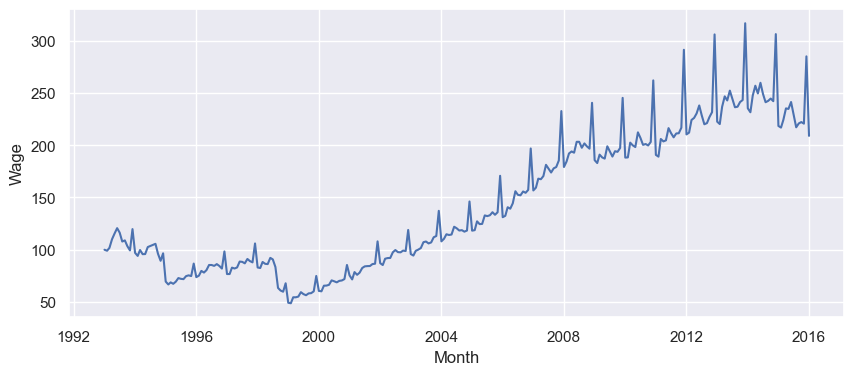

In [74]:
plt.figure(figsize=(10, 4))
sns.lineplot(data=df, x=df.index, y=df['Wage']) # визуализируем временной ряд

В данных наблюдается тренд и сезонность.

### Декомпозиция ряда

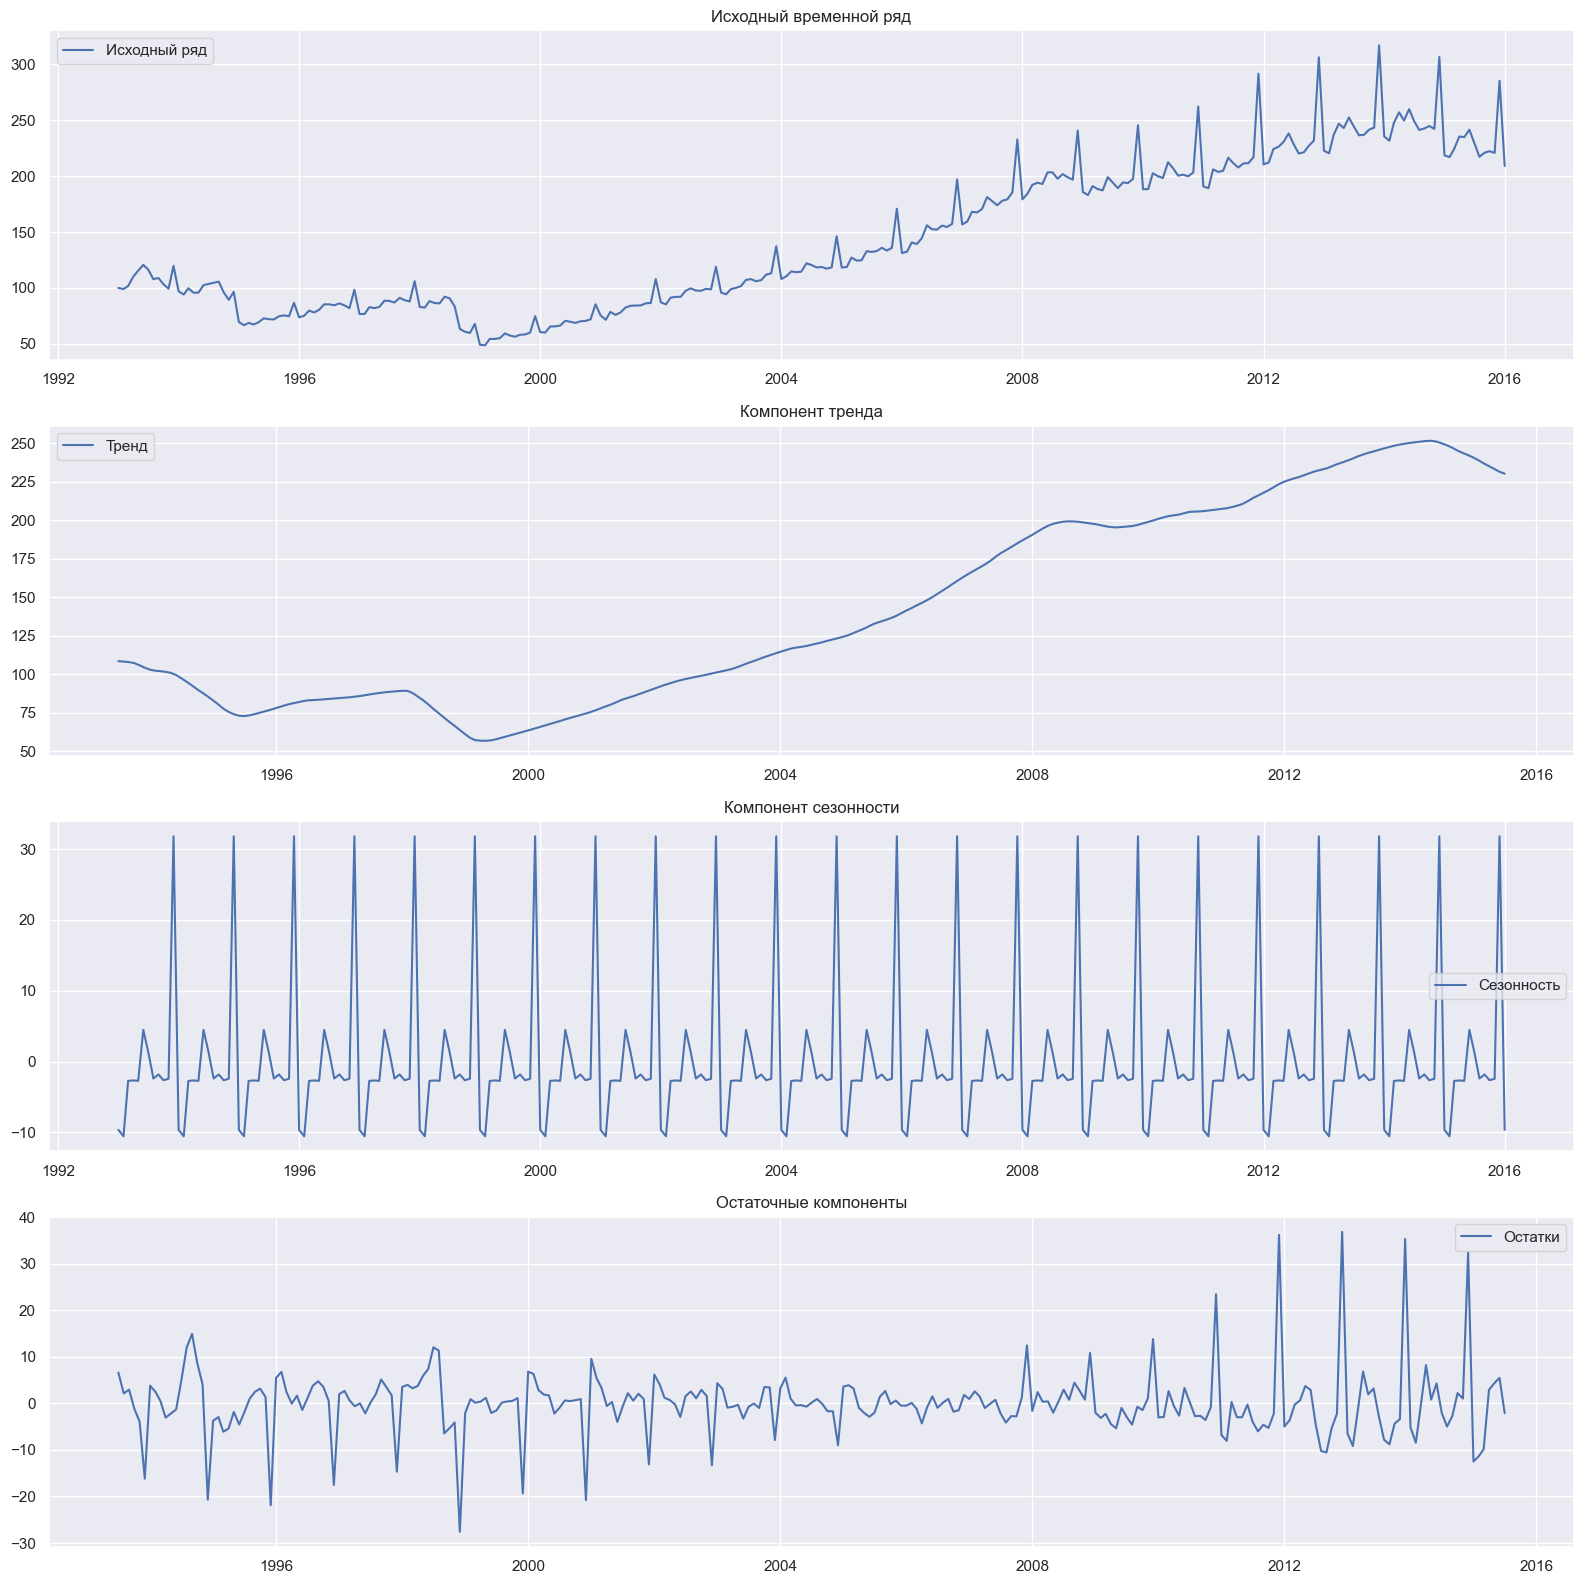

In [75]:
decomposition = seasonal_decompose(df, model='additive')

# Извлечение компонентов тренда, сезонности и остатков
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(16, 16))

# График исходного временного ряда
plt.subplot(411)
plt.plot(df.index, df['Wage'], label='Исходный ряд')
plt.legend(loc='best')
plt.title('Исходный временной ряд')


# График компонента тренда
plt.subplot(412)
plt.plot(trend, label='Тренд')
plt.legend(loc='best')
plt.title('Компонент тренда')

# График компонента сезонности
plt.subplot(413)
plt.plot(seasonal, label='Сезонность')
plt.legend(loc='best')
plt.title('Компонент сезонности')

# График остаточных компонентов
plt.subplot(414)
plt.plot(residual, label='Остатки')
plt.legend(loc='best')
plt.title('Остаточные компоненты')

plt.tight_layout()
plt.show()

In [76]:
adft = adfuller(df)
print('p-value: ', adft[1])

p-value:  0.9231115414958134


Вывод: ряд не является стационарным. Это закономерно, поскольку в нём присутствуют явный тренд и сезонность.

In [77]:
df['Wage_dif1'] = df['Wage'] - df['Wage'].shift(1) #один раз дифференцируем ряд
adft = adfuller(df['Wage_dif1'].dropna(),autolag="AIC")
print('p-value: ', adft[1])

p-value:  0.008507613679230266


Однократно дифференцированный ряд стал стационарным на 5% уровне значимости.

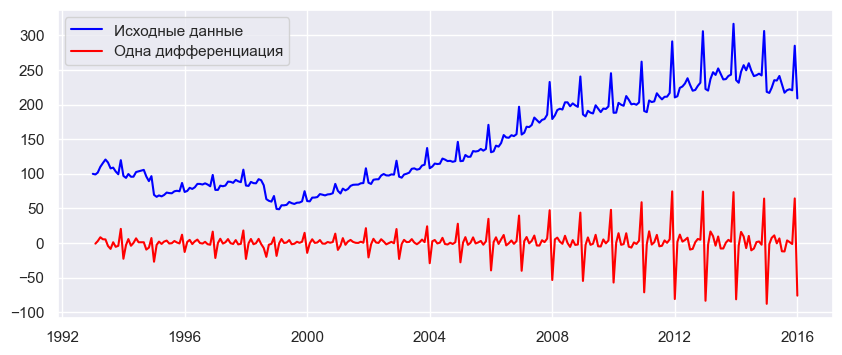

In [78]:
plt.figure(figsize=(10, 4))
plt.plot(df['Wage'], color="blue",label="Исходные данные")
plt.plot(df['Wage_dif1'], color="red", label="Одна дифференциация")
plt.legend(loc="best")

### Автокорреляция

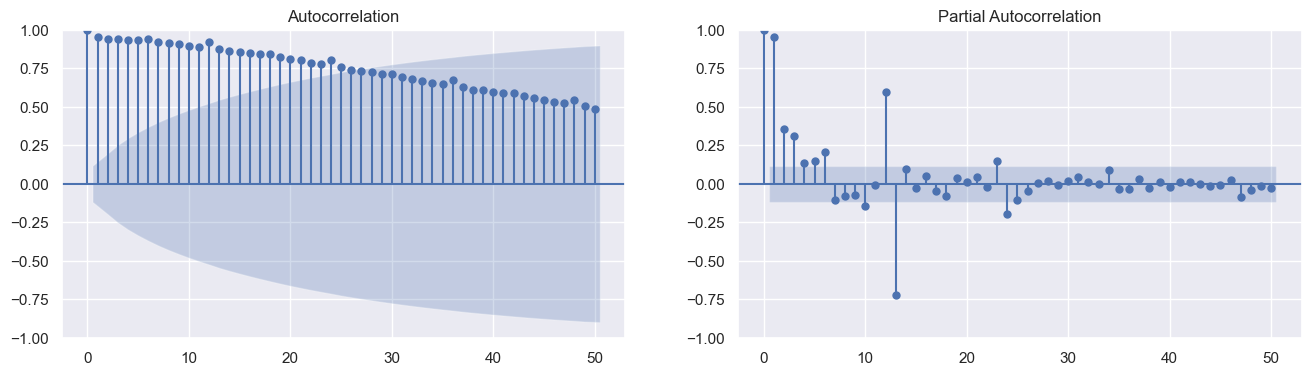

In [79]:
fig, axes = plt.subplots(1,2,figsize=(16,4), dpi= 100)
plot_acf(df['Wage'], lags=50, ax=axes[0])
plot_pacf(df['Wage'], lags=50, ax=axes[1])
plt.show()

### Разделение ряда на обучающую и тестовую выборки

Обучающая выборка: данные до февраля 2013 года.

In [80]:
df = pd.read_csv("monthly-wage.csv")
df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m')
df.index = df['Month']
del df['Month']

In [81]:
df['Date'] = df.index
train = df[df['Date'] < "2013-02"]
del train['Date']
train = train.rename(columns={'Wage': 'train'}) 
train

,train
Month,
1993-01-01,100.00
1993-02-01,99.04
1993-03-01,101.77
1993-04-01,110.05
1993-05-01,115.47
...,...
2012-09-01,221.20
2012-10-01,227.00
2012-11-01,231.70


Тестовая выборка: данные после февраля 2013 года включительно.

In [82]:
test = df[df['Date'] >= "2013-02"]
del test['Date']
test = test.rename(columns={'Wage': 'test'}) 
test

,test
Month,
2013-02-01,220.3
2013-03-01,236.9
2013-04-01,246.8
2013-05-01,242.9
2013-06-01,252.3
2013-07-01,244.3
2013-08-01,236.4
2013-09-01,236.9
2013-10-01,241.4


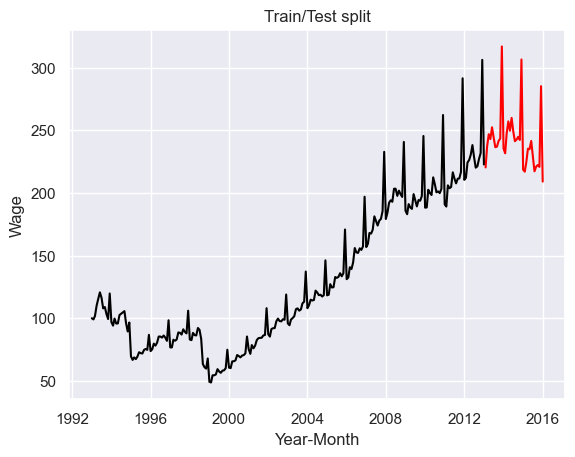

In [83]:
plt.plot(train, color = "black") #обучающая выборка
plt.plot(test, color = "red") #тестовая выборка
plt.title("Train/Test split")
plt.ylabel("Wage")
plt.xlabel('Year-Month')
sns.set()
plt.show()

### ARIMA

In [84]:
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train)
forecast = model.predict(n_periods=len(test))
forecast = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1938.598, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2042.880, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1986.388, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1937.805, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2041.099, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1939.112, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1938.793, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1941.702, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1940.840, Time=0.02 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.446 seconds


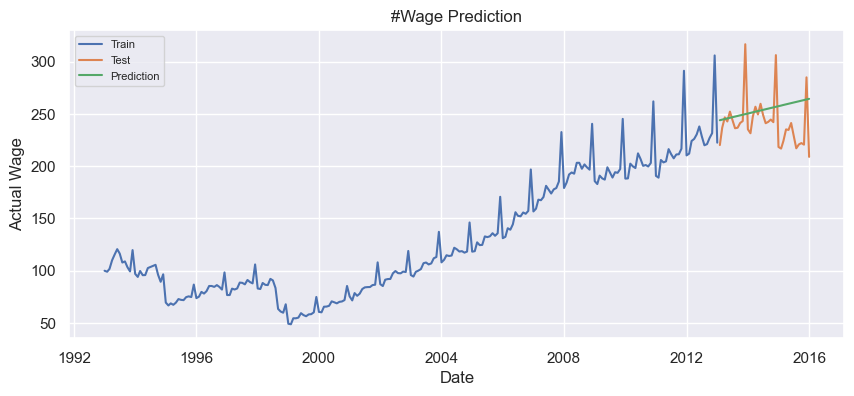

In [85]:
plt.figure(figsize=(10, 4))
plt.plot(train, label='Train') #обучающая выборка
plt.plot(test, label='Test') #тестовая выборка
plt.plot(forecast, label='Prediction') #предсказанные значения

plt.title('#Wage Prediction')
plt.xlabel('Date')
plt.ylabel('Actual Wage')
plt.legend(loc='upper left', fontsize=8)


In [86]:
df.index = pd.DatetimeIndex(df.index.values, freq=df.index.inferred_freq)

In [87]:
model  =  ARIMA(df['Wage'], order=(0, 1, 1))
res = model.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                   Wage   No. Observations:                  277
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -1146.356
Date:                Mon, 27 Jan 2025   AIC                           2296.712
Time:                        14:34:47   BIC                           2303.953
Sample:                    01-01-1993   HQIC                          2299.618
                         - 01-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7372      0.036    -20.509      0.000      -0.808      -0.667
sigma2       236.5606      8.477     27.907      0.000     219.946     253.175
Ljung-Box (L1) (Q):                   0.99   Jarque-

In [88]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error, r2_score

def regression_quality_metrics_report(y_true, y_pred):
    
    rmse = np.sqrt( mean_squared_error(y_true, y_pred) )
    mae = mean_absolute_error(y_true, y_pred)
    rse = np.sqrt( ( (y_true - y_pred)**2 ).sum() / ( (y_true - y_true.mean())**2 ).sum() )
    rae = np.abs( y_true - y_pred ).sum() / np.abs( y_true - y_true.mean() ).sum()
    mape = 100. / len(y_true) * np.abs( 1. - y_pred/y_true ).sum()
    
    
    return [rmse, mae, rse, rae, mape]

In [89]:
metrics_report = pd.DataFrame(columns=['RMSE', 'MAE', 'RSE', 'RAE', 'MAPE'])

metrics_report.loc['SARIMA', :] = regression_quality_metrics_report(test['test'].values, forecast['Prediction'].values)

metrics_report

,RMSE,MAE,RSE,RAE,MAPE
SARIMA,27.370556,21.27147,1.228237,1.454183,8.949155


<Axes: >

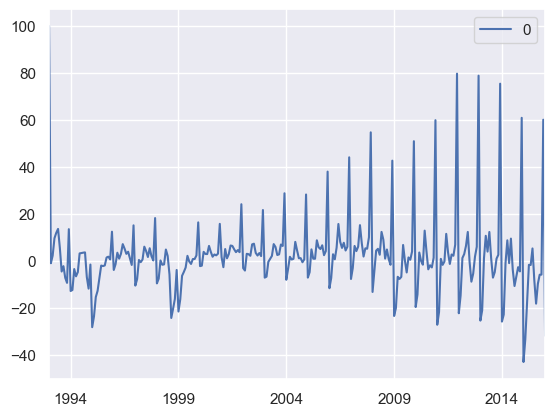

In [90]:
# визуализация остатков
residuals = pd.DataFrame(res.resid)
residuals.plot()

In [91]:
metrics_report = pd.DataFrame(columns=['RMSE', 'MAE', 'RSE', 'RAE', 'MAPE', 'RMSLE'])

metrics_report.loc['ARIMA', :] = regression_quality_metrics_report(test['test'].values, forecast['Prediction'].values)

metrics_report

ValueError: could not broadcast input array from shape (5,) into shape (6,)

In [92]:
#учтем сезонный компонент
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True, seasonal = True, m=12)
model.fit(train)
forecast = model.predict(n_periods=len(test))
forecast = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=1337.149, Time=0.79 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1339.333, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1334.441, Time=0.07 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1336.317, Time=0.09 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1340.937, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1334.117, Time=0.18 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=1323.587, Time=0.75 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=1332.729, Time=0.22 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=inf, Time=1.88 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=1306.047, Time=0.77 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=1334.690, Time=0.30 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1336.310, Time=0.08 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=1304.073, Time=0.68 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=1332.757, Time=0.25 sec
 ARIMA(0,1,0)(1,1,1)[12]

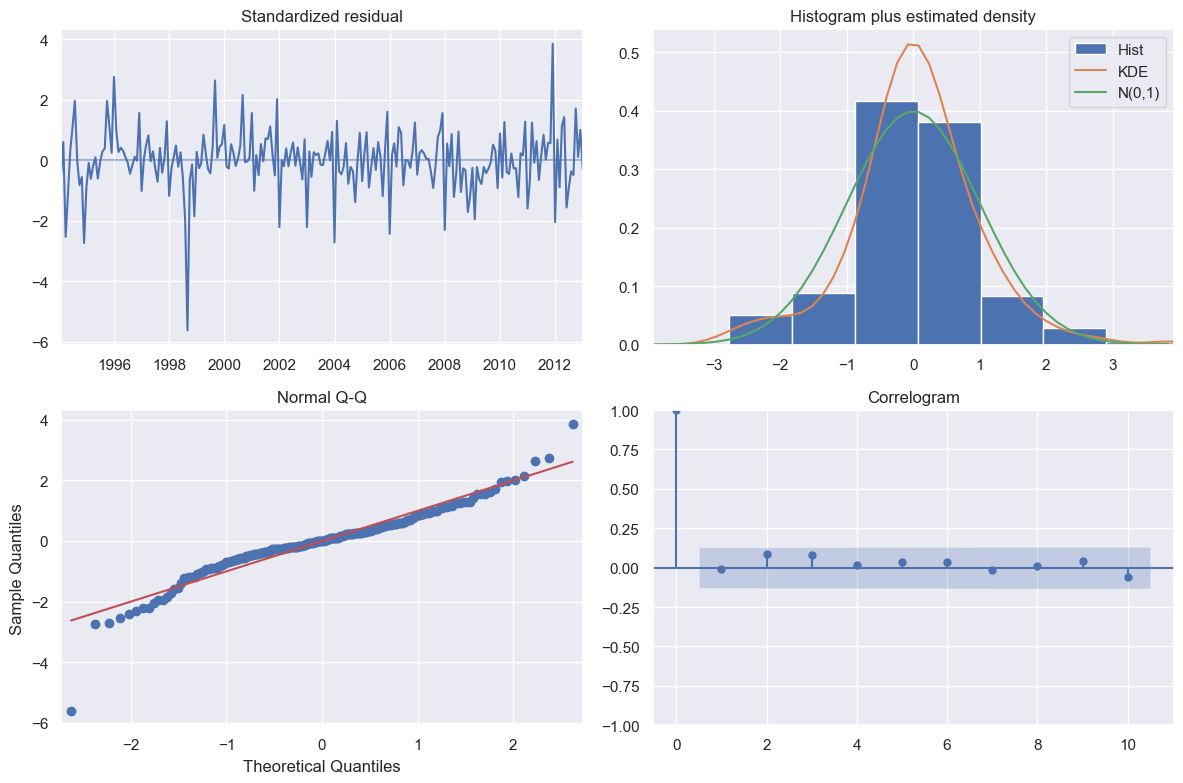

In [93]:
model.plot_diagnostics(figsize=(12,8))
plt.tight_layout()
plt.show()

In [94]:
model  =  ARIMA(df['Wage'], order=(0, 1, 0), seasonal_order=(1, 1, 2, 12))
res = model.fit()
print(res.summary())

                                       SARIMAX Results                                       
Dep. Variable:                                  Wage   No. Observations:                  277
Model:             ARIMA(0, 1, 0)x(1, 1, [1, 2], 12)   Log Likelihood                -763.249
Date:                               Mon, 27 Jan 2025   AIC                           1534.499
Time:                                       14:35:14   BIC                           1548.803
Sample:                                   01-01-1993   HQIC                          1540.247
                                        - 01-01-2016                                         
Covariance Type:                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.8020      0.108      7.403      0.000       0.590       1.014
ma.S.L12   

In [95]:
metrics_report = pd.DataFrame(columns=['RMSE', 'MAE', 'RSE', 'RAE', 'MAPE'])

metrics_report.loc['SARIMA', :] = regression_quality_metrics_report(test['test'].values, forecast['Prediction'].values)

metrics_report

,RMSE,MAE,RSE,RAE,MAPE
SARIMA,20.051687,13.772879,0.899807,0.941556,5.812545


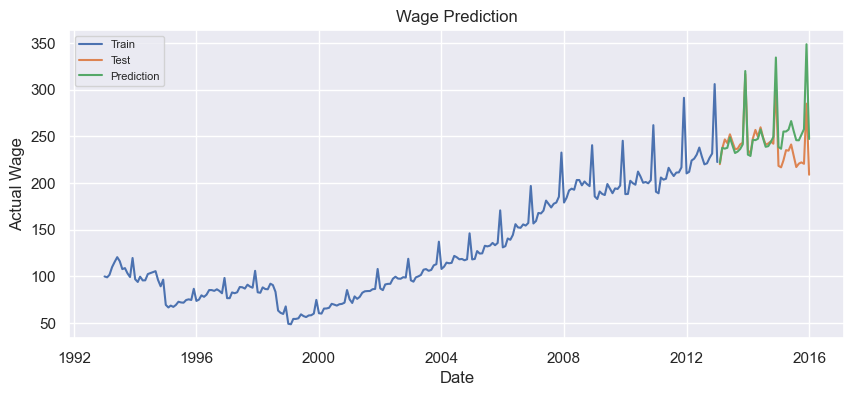

In [96]:
plt.figure(figsize=(10, 4))
plt.plot(train, label='Train') #обучающая выборка
plt.plot(test, label='Test') #тестовая выборка
plt.plot(forecast, label='Prediction') #предсказанные значения

plt.title('Wage Prediction')
plt.xlabel('Date')
plt.ylabel('Actual Wage')
plt.legend(loc='upper left', fontsize=8)